 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [ ]:
# !pip install torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F  # Functional

from tqdm import notebook

Скачаем обучающую и контрольную выборки.

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ("T-shirt/top", 
           "Trouser", 
           "Pullover", 
           "Dress", 
           "Coat", 
           "Sandal", 
           "Shirt", 
           "Sneaker", 
           "Bag", 
           "Ankle boot")

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [ ]:
print('Images in train:', len(trainset),
      '\nImages in test: ', len(testset))

Images in train: 60000 
Images in test:  10000


In [ ]:
data = trainset.targets.unique(return_counts=True)
dict(zip(data[0].numpy(), data[1].numpy()))

{0: 6000,
 1: 6000,
 2: 6000,
 3: 6000,
 4: 6000,
 5: 6000,
 6: 6000,
 7: 6000,
 8: 6000,
 9: 6000}

Каждый элемент одежды встречается в выборке 6000 раз. Распределение можно считать равномерным

In [ ]:
data = testset.targets.unique(return_counts=True)
dict(zip(data[0].numpy(), data[1].numpy()))

{0: 1000,
 1: 1000,
 2: 1000,
 3: 1000,
 4: 1000,
 5: 1000,
 6: 1000,
 7: 1000,
 8: 1000,
 9: 1000}

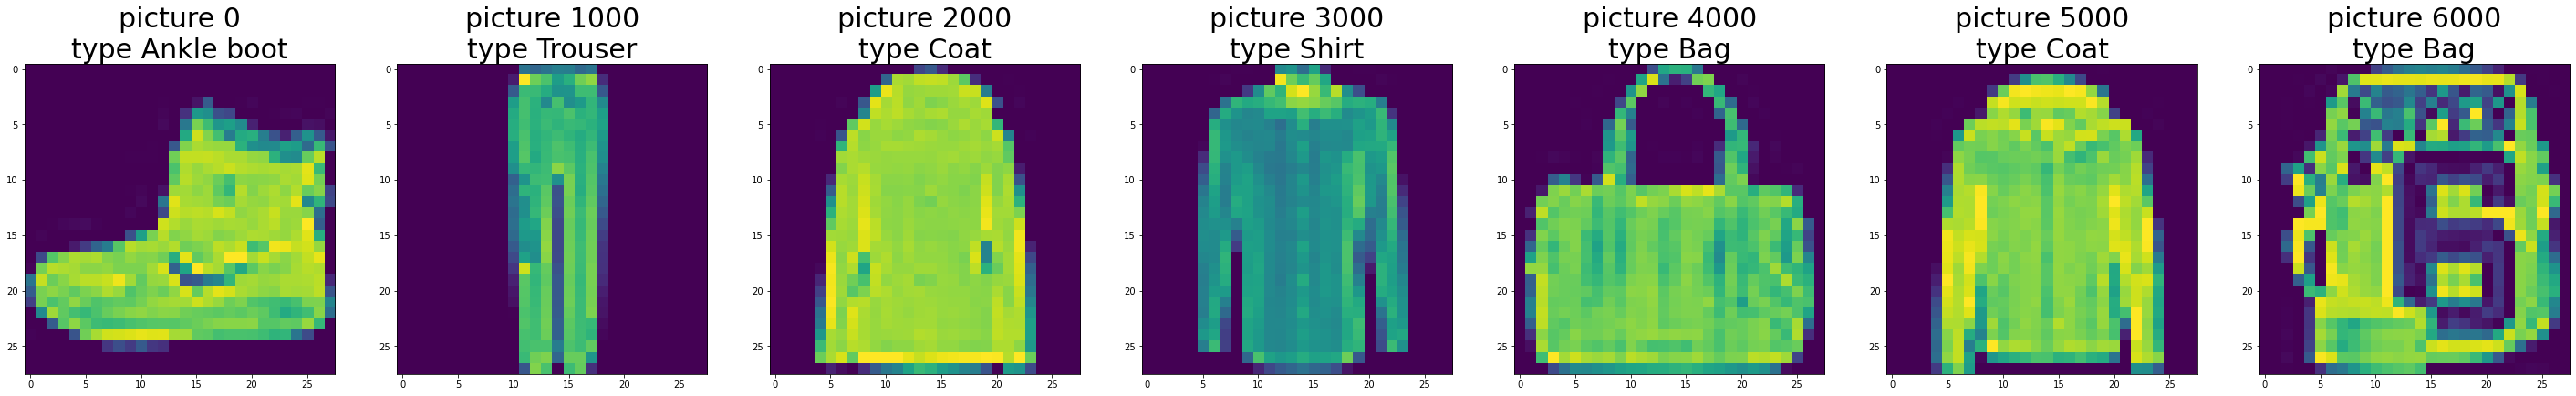

In [ ]:
fig = plt.figure(figsize=(50,160))

item = 1
for i in np.arange(0, 6001, 1000) :
    ax = fig.add_subplot(1, 7, item)
    item += 1
    imgplot = plt.imshow(trainset.data[i])

    ax.set_title('picture ' + str(i) + 
                 '\ntype ' + str(classes[trainset.targets[i].item()]), 
                 fontsize=30)

In [ ]:
def fit(net_model, optimizer, loss_fn, epochs = 3):
    losses = []
    for epoch in notebook.tqdm(range(epochs)):
        running_loss = 0.0
        for i, batch in enumerate(notebook.tqdm(trainloader)):
            X_batch, y_batch = batch
            optimizer.zero_grad()

            y_pred = net_model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if i % 2000 == 1999:
                mean_loss = running_loss / 2000
                running_loss = 0.0
                losses.append(mean_loss)

                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, mean_loss))
                
    print('Обучение закончено')
    return losses

In [ ]:
def test_report(net_model, class_count=10):  
    class_correct = list(0. for i in range(class_count))
    class_total = list(0. for i in range(class_count))

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            y_pred = net_model(images)
            _, predicted = torch.max(y_pred, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(class_count):
        class_correct[i] = 100 * class_correct[i] / class_total[i]
        print('Accuracy of %5s : %2d %%' % (
              classes[i], class_correct[i]))
        
    return class_correct

In [ ]:
def visualize_result(net_model, index):
    image = testloader.dataset.data[index].numpy()
    plt.imshow(image)
    
    y_pred = net_model(torch.Tensor(image).view(1, 1, 28, 28))
    _, predicted = torch.max(y_pred, 1)
    
    plt.title(f'Predicted: {predicted}')

In [ ]:
class MLPNet(nn.Module):
    def __init__(self, n_count):
        super(MLPNet, self).__init__()
        
        self.fc1 = nn.Linear(1 * 28 * 28, n_count)
        self.fc2 = nn.Linear(n_count, n_count)
        self.fc3 = nn.Linear(n_count, n_count)
        self.fc4 = nn.Linear(n_count, 10)

        self.drop1 = nn.Dropout(p=0.1)
        self.drop2 = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
    
  
    def forward(self, x):
        x = x.view(-1, 1 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.drop1(x)
        x = self.relu(self.fc3(x))
        x = self.drop2(x)
        x = self.fc4(x)
        return x

In [ ]:
mlp_net = MLPNet(256)

loss_fn_mlp = torch.nn.CrossEntropyLoss(size_average=False)
learning_rate = 1e-2
optimizer_mlp = torch.optim.SGD(mlp_net.parameters(), lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 3.926
[1,  4000] loss: 2.491
[1,  6000] loss: 2.162
[1,  8000] loss: 1.995
[1, 10000] loss: 2.024
[1, 12000] loss: 1.894
[1, 14000] loss: 1.919


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 1.781
[2,  4000] loss: 1.703
[2,  6000] loss: 1.709
[2,  8000] loss: 1.648
[2, 10000] loss: 1.669
[2, 12000] loss: 1.590
[2, 14000] loss: 1.570


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 1.554
[3,  4000] loss: 1.528
[3,  6000] loss: 1.495
[3,  8000] loss: 1.503
[3, 10000] loss: 1.447
[3, 12000] loss: 1.418
[3, 14000] loss: 1.520
Обучение закончено


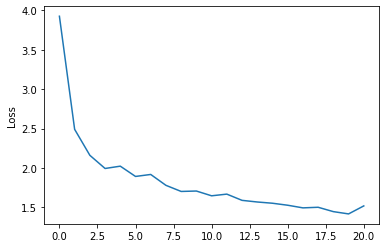

Accuracy of T-shirt/top : 85 %
Accuracy of Trouser : 94 %
Accuracy of Pullover : 74 %
Accuracy of Dress : 90 %
Accuracy of  Coat : 81 %
Accuracy of Sandal : 94 %
Accuracy of Shirt : 57 %
Accuracy of Sneaker : 95 %
Accuracy of   Bag : 97 %
Accuracy of Ankle boot : 94 %
Accuracy: 86.56 %


In [ ]:
losses_mlp = fit(mlp_net, optimizer_mlp, loss_fn_mlp)

plt.plot(losses_mlp)
plt.ylabel('Loss')
plt.show()

correct_mlp = test_report(mlp_net)
print('Accuracy: %.2f %%' % ((np.array(correct_mlp)).mean()))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 3.890
[1,  4000] loss: 2.430
[1,  6000] loss: 2.212
[1,  8000] loss: 1.992
[1, 10000] loss: 1.788
[1, 12000] loss: 1.821
[1, 14000] loss: 1.735


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 1.601
[2,  4000] loss: 1.529
[2,  6000] loss: 1.538
[2,  8000] loss: 1.550
[2, 10000] loss: 1.491
[2, 12000] loss: 1.501
[2, 14000] loss: 1.469


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 1.395
[3,  4000] loss: 1.375
[3,  6000] loss: 1.401
[3,  8000] loss: 1.323
[3, 10000] loss: 1.337
[3, 12000] loss: 1.326
[3, 14000] loss: 1.348
Обучение закончено


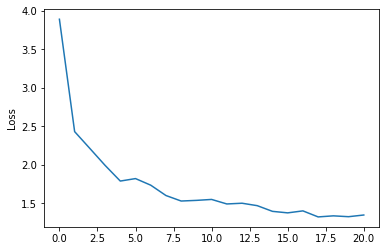

Accuracy of T-shirt/top : 87 %
Accuracy of Trouser : 96 %
Accuracy of Pullover : 82 %
Accuracy of Dress : 87 %
Accuracy of  Coat : 80 %
Accuracy of Sandal : 95 %
Accuracy of Shirt : 52 %
Accuracy of Sneaker : 94 %
Accuracy of   Bag : 97 %
Accuracy of Ankle boot : 95 %
Accuracy: 86.89 %


In [ ]:
mlp_net_1 = MLPNet(256)

loss_fn_mlp = torch.nn.CrossEntropyLoss(size_average=False)
learning_rate = 1e-4
optimizer_mlp = torch.optim.Adam(mlp_net_1.parameters(), lr=learning_rate)

losses_mlp_1 = fit(mlp_net_1, optimizer_mlp, loss_fn_mlp)

plt.plot(losses_mlp_1)
plt.ylabel('Loss')
plt.show()

correct_mlp_1 = test_report(mlp_net_1)
print('Accuracy: %.2f %%' % ((np.array(correct_mlp_1)).mean()))

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, padding=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)  
        self.fc2 = nn.Linear(256, 256)  
        self.fc3 = nn.Linear(256, 10)

        self.drop = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop(x)
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.drop(x)
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
conv_net = ConvNet()
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(conv_net.parameters(), lr=learning_rate)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 0.882
[1,  4000] loss: 0.571
[1,  6000] loss: 0.497
[1,  8000] loss: 0.447
[1, 10000] loss: 0.428
[1, 12000] loss: 0.405
[1, 14000] loss: 0.364


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.325
[2,  4000] loss: 0.342
[2,  6000] loss: 0.337
[2,  8000] loss: 0.298
[2, 10000] loss: 0.313
[2, 12000] loss: 0.313
[2, 14000] loss: 0.290


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.271
[3,  4000] loss: 0.250
[3,  6000] loss: 0.269
[3,  8000] loss: 0.265
[3, 10000] loss: 0.264
[3, 12000] loss: 0.259
[3, 14000] loss: 0.250
Обучение закончено


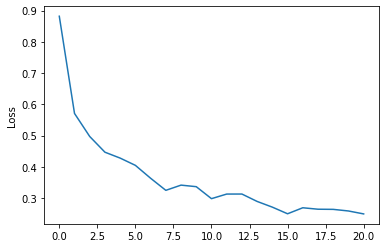

In [ ]:
losses = fit(conv_net, optimizer, loss_fn)

plt.plot(losses)
plt.ylabel('Loss')
plt.show()

In [ ]:
correct = test_report(conv_net)
print('Accuracy: %.2f %%' % ((np.array(correct)).mean()))

Accuracy of T-shirt/top : 87 %
Accuracy of Trouser : 97 %
Accuracy of Pullover : 88 %
Accuracy of Dress : 92 %
Accuracy of  Coat : 81 %
Accuracy of Sandal : 96 %
Accuracy of Shirt : 70 %
Accuracy of Sneaker : 95 %
Accuracy of   Bag : 98 %
Accuracy of Ankle boot : 96 %
Accuracy: 90.56 %


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 0.910
[1,  4000] loss: 0.595
[1,  6000] loss: 0.492
[1,  8000] loss: 0.452
[1, 10000] loss: 0.413
[1, 12000] loss: 0.392
[1, 14000] loss: 0.375


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.345
[2,  4000] loss: 0.329
[2,  6000] loss: 0.326
[2,  8000] loss: 0.302
[2, 10000] loss: 0.307
[2, 12000] loss: 0.300
[2, 14000] loss: 0.292


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.265
[3,  4000] loss: 0.254
[3,  6000] loss: 0.267
[3,  8000] loss: 0.257
[3, 10000] loss: 0.262
[3, 12000] loss: 0.248
[3, 14000] loss: 0.246


  0%|          | 0/15000 [00:00<?, ?it/s]

[4,  2000] loss: 0.231
[4,  4000] loss: 0.227
[4,  6000] loss: 0.221
[4,  8000] loss: 0.221
[4, 10000] loss: 0.217
[4, 12000] loss: 0.222
[4, 14000] loss: 0.226
Обучение закончено


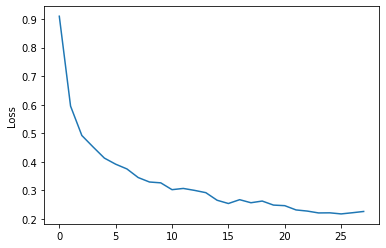

Accuracy of T-shirt/top : 87 %
Accuracy of Trouser : 98 %
Accuracy of Pullover : 81 %
Accuracy of Dress : 91 %
Accuracy of  Coat : 93 %
Accuracy of Sandal : 95 %
Accuracy of Shirt : 70 %
Accuracy of Sneaker : 96 %
Accuracy of   Bag : 98 %
Accuracy of Ankle boot : 96 %
Accuracy: 90.98 %


In [ ]:
conv_net_4 = ConvNet()
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(conv_net_4.parameters(), lr=learning_rate)

losses_4 = fit(conv_net_4, optimizer, loss_fn, 4)

plt.plot(losses_4)
plt.ylabel('Loss')
plt.show()

correct_4 = test_report(conv_net_4)
print('Accuracy: %.2f %%' % ((np.array(correct_4)).mean()))

Из полученных значений видно, что лучше с классификацией картинок справляется сверточная нейронная сеть. С оптимизатором Adam и выбранными параметрамы удалось достичь точности практически 91%

На многослойной сети не удалось преодолеть планку 87%. На выбранных параметрах немного лучше справлялся оптимизатор Adam для обейх сетей.

Графики loss выглядят единообразно. На первых эпохах идет резкое снижение потерь, однако с каждой следующей эпохой скорость уменьшения ошибки снижается вплоть до стагнации, когда начинаются скачки вверх - переобучение. 

В нашей задаче хорошо работает количество эпох 3-4. Далее точность моделей либо растет несущественно, либо падает.
